Pollution Response Dataset

In [ ]:
import pandas as pd
import urllib
import json
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
geolocator = Nominatim(user_agent="ENVEQ")
pollution = pd.read_csv("https://opendata.arcgis.com/datasets/0f969f1e7679463c8ec5a121b9ec10cb_175.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")

In [ ]:
pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   X                              7652 non-null   float64
 1   Y                              7652 non-null   float64
 2   OBJECTID                       7652 non-null   int64  
 3   REFERENCE_POINT                7652 non-null   object 
 4   PRP_REPORT_ID                  7651 non-null   float64
 5   PRP_REPORT_RECEIVED_DATE_TIME  7652 non-null   object 
 6   PRP_INCIDENT_DATE_TIME         7652 non-null   object 
 7   PRP_INCIDENT_CLOSURE_DATE      7652 non-null   object 
 8   RSC_STATUS_DESCRIPTION         7651 non-null   object 
 9   SRC_STATUS_REASON_DESC         6915 non-null   object 
 10  PRP_SITE_NAME                  7644 non-null   object 
 11  PRP_SITE_ADDRESS1              7361 non-null   object 
 12  PRP_SITE_ADDRESS2              325 non-null    o

In [ ]:
pollution.head(5)

,X,Y,OBJECTID,REFERENCE_POINT,PRP_REPORT_ID,PRP_REPORT_RECEIVED_DATE_TIME,PRP_INCIDENT_DATE_TIME,PRP_INCIDENT_CLOSURE_DATE,RSC_STATUS_DESCRIPTION,SRC_STATUS_REASON_DESC,PRP_SITE_NAME,PRP_SITE_ADDRESS1,PRP_SITE_ADDRESS2,PRP_SITE_CITY,PRP_SITE_STATE,PRP_SITE_ZIP_CODE,PRP_ASSIGNED_STAFF_PROGRAM_ID
0,-8.496225e+06,4.400668e+06,1,PG,292958.0,2019/12/03 19:36:00+00,2019/12/03 19:36:00+00,2019/12/04 07:59:20+00,Closed,Not within DEQ jurisdiction. Referred to exter...,Propane Release,2035 Sunset Maple Ln,NaN,Chesapeake,VA,23323,261.0
1,-9.125118e+06,4.394886e+06,2,PG,292960.0,2019/12/03 15:34:00+00,2019/12/03 14:45:00+00,2020/01/15 09:27:30+00,Closed,Appropriate compliance actions completed and v...,Burning demolished house,Green Springs Road,NaN,Abingdon,VA,24210,269.0
2,-8.778320e+06,4.642689e+06,3,PG,292969.0,2019/12/02 13:30:00+00,2019/12/02 12:00:00+00,2019/12/04 14:48:06+00,Closed,Appropriate compliance actions completed and v...,SSO - City of Harrisonburg,608 Franklin St,NaN,Harrisonburg,VA,22801,41.0
3,-8.811512e+06,4.497424e+06,4,FC,292981.0,2019/12/05 15:55:58+00,2019/12/05 14:43:00+00,2019/12/09 08:26:54+00,Closed,Pollution report being managed by a media-spec...,Heating Oil Tank Release - 75 Gallons - Ground...,102 Polk Street,NaN,Lynchburg,VA,24504,302.0
4,-8.799619e+06,4.429732e+06,5,FC,292982.0,2019/12/05 16:15:41+00,2019/12/05 14:34:00+00,2020/01/09 14:32:56+00,Closed,Appropriate compliance actions completed and v...,Uncovered/Unspread Chicken Litter Pile,4027 Leda Grove Road,NaN,Nathalie,VA,24577,72.0


In [ ]:
pollution_subset = pollution[["PRP_SITE_ADDRESS1", "PRP_SITE_CITY", "PRP_SITE_ZIP_CODE"]].dropna(axis=0, how="all")
pollution_subset = pollution_subset.drop_duplicates()
pollution_subset = pollution_subset.applymap(str)
pollution_subset.head()

,PRP_SITE_ADDRESS1,PRP_SITE_CITY,PRP_SITE_ZIP_CODE
0,2035 Sunset Maple Ln,Chesapeake,23323
1,Green Springs Road,Abingdon,24210
2,608 Franklin St,Harrisonburg,22801
3,102 Polk Street,Lynchburg,24504
4,4027 Leda Grove Road,Nathalie,24577


In [ ]:
pollution_subset["FULL_ADDRESS"] = pollution_subset.apply(lambda row: row.PRP_SITE_ADDRESS1 + "," + row.PRP_SITE_CITY + ",VA,United States", axis=1)
pollution_subset["MIN_ADDRESS"] = pollution_subset.apply(lambda row: row.PRP_SITE_CITY+ ",VA,United States", axis=1)
pollution_subset.head()
print(pollution_subset.shape)

(6461, 5)


In [ ]:
# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.9)
# 2- - create location column
pollution_subset["LOCATION"] = pollution_subset["FULL_ADDRESS"].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
pollution_subset["POINT"] = pollution_subset["LOCATION"].apply(lambda loc: tuple(loc.point) if loc else None)

In [ ]:
# 4 - split point column into latitude, longitude and altitude columns
pollution_subset[["LAT", "LON", "ALT"]] = pd.DataFrame(pollution_subset["POINT"].tolist(), index=pollution_subset.index)

In [ ]:
#delete rows without lat,lon information
pollution_subset = pollution_subset.dropna(axis=0, how="any")
print("Number of rows:",pollution_subset.shape[0])
pollution_subset.head()

Number of rows: 3278


,PRP_SITE_ADDRESS1,PRP_SITE_CITY,PRP_SITE_ZIP_CODE,FULL_ADDRESS,MIN_ADDRESS,LOCATION,POINT,LAT,LON,ALT
0,2035 Sunset Maple Ln,Chesapeake,23323,"2035 Sunset Maple Ln,Chesapeake,VA,United States","Chesapeake,VA,United States","(2035, Sunset Maple Lane, Grassfield, Chesapea...","(36.72363695, -76.32287478049942, 0.0)",36.723637,-76.322875,0.0
2,608 Franklin St,Harrisonburg,22801,"608 Franklin St,Harrisonburg,VA,United States","Harrisonburg,VA,United States","(608, Franklin Street, Preston Heights, Harris...","(38.446588180491524, -78.85729824043148, 0.0)",38.446588,-78.857298,0.0
3,102 Polk Street,Lynchburg,24504,"102 Polk Street,Lynchburg,VA,United States","Lynchburg,VA,United States","(102, Polk Street, Garland Hill, Lynchburg, Ly...","(37.417206101977875, -79.15526389517936, 0.0)",37.417206,-79.155264,0.0
6,210 Emmet Street South,Charlottesville,22903,"210 Emmet Street South,Charlottesville,VA,Unit...","Charlottesville,VA,United States","(Emmet Street South, Lewis Mountain, Charlotte...","(38.0397401, -78.5067118, 0.0)",38.039740,-78.506712,0.0
7,nan,Midlothian,nan,"nan,Midlothian,VA,United States","Midlothian,VA,United States","(Midlothian Post Office, 14722, Crawford Avenu...","(41.6247325, -87.71808525943396, 0.0)",41.624733,-87.718085,0.0


In [ ]:
# Remove rows that do not conform to the boundaries of Virginia
pollution_cleaned = pollution_subset[pollution_subset["LON"] < -75]
pollution_cleaned = pollution_cleaned[pollution_cleaned["LON"] > -83]
pollution_cleaned = pollution_cleaned[pollution_cleaned["LAT"] < 39]
pollution_cleaned = pollution_cleaned[pollution_cleaned["LAT"] > 36]
pollution_cleaned.head()

,PRP_SITE_ADDRESS1,PRP_SITE_CITY,PRP_SITE_ZIP_CODE,FULL_ADDRESS,MIN_ADDRESS,LOCATION,POINT,LAT,LON,ALT
0,2035 Sunset Maple Ln,Chesapeake,23323,"2035 Sunset Maple Ln,Chesapeake,VA,United States","Chesapeake,VA,United States","(2035, Sunset Maple Lane, Grassfield, Chesapea...","(36.72363695, -76.32287478049942, 0.0)",36.723637,-76.322875,0.0
2,608 Franklin St,Harrisonburg,22801,"608 Franklin St,Harrisonburg,VA,United States","Harrisonburg,VA,United States","(608, Franklin Street, Preston Heights, Harris...","(38.446588180491524, -78.85729824043148, 0.0)",38.446588,-78.857298,0.0
3,102 Polk Street,Lynchburg,24504,"102 Polk Street,Lynchburg,VA,United States","Lynchburg,VA,United States","(102, Polk Street, Garland Hill, Lynchburg, Ly...","(37.417206101977875, -79.15526389517936, 0.0)",37.417206,-79.155264,0.0
6,210 Emmet Street South,Charlottesville,22903,"210 Emmet Street South,Charlottesville,VA,Unit...","Charlottesville,VA,United States","(Emmet Street South, Lewis Mountain, Charlotte...","(38.0397401, -78.5067118, 0.0)",38.039740,-78.506712,0.0
13,9324 Virginia ave.,NORFOLK,23511,"9324 Virginia ave.,NORFOLK,VA,United States","NORFOLK,VA,United States","(Virginia Avenue, Norfolk, Virginia, 23511-289...","(36.9373437, -76.3218385, 0.0)",36.937344,-76.321838,0.0


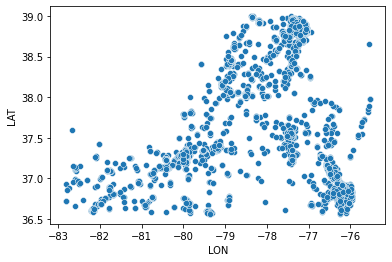

In [ ]:
# graph the data to see whether it looks like Virginia
import seaborn as sns
sns.scatterplot(x="LON", y="LAT", data=pollution_cleaned)

In [ ]:
# Zip the dataset into a csv file and save it locally
import pickle
print(pollution_cleaned.shape[0])
pollution_final = pollution_cleaned[["FULL_ADDRESS", "MIN_ADDRESS","LAT","LON"]]
pollution_final.to_pickle("pollution_reports.pkl")

3062
